# 第四章　Monte Carlo法：Monte Carlo积分

作者：[王何宇](http://person.zju.edu.cn/wangheyu)

[浙江大学数学科学学院](http://www.math.zju.edu.cn)

本文档配合讲义第四章。讲义中的代码和图形都可在此验证。

In [1]:
from __future__ import print_function, division

# 这句话是非标准的python，用于ipthon或jupyter这样的系统中，表示绘图即刻自动展开。
%matplotlib inline

# 这里把全部Warning过滤掉了. 
# 参见https://docs.python.org/2/library/warnings.html
import warnings
warnings.filterwarnings('ignore')
from scipy.special import comb, perm
from scipy import stats
import numpy as np
import sys
import matplotlib.pyplot as plt
np.random.seed(250)

下面给一个一维MC积分的例子，
$$
I = \int_a^b f(x) dx \approx \frac{b - a}{n} \sum_{i = 1}^n f(X),
$$
其中$X \sim U(a, b)$.

In [2]:
def obj_fun(x):
    return np.sin(x)

def MC_Int(a, b, times):
    S = 0
    X = np.random.rand(times)*(b - a)
    for i in range(times):
        S += obj_fun(X[i])
    return (b - a) * S / times

In [3]:
MC_Int(0, 2*np.pi, 100000)

0.005197255412452262

对结构较为复杂的函数，更能体现优势。（注意在求面积时的例子有bug，已修改）

In [4]:
def obj_fun(x):
    return 0.5 * np.sin(1/x) + 0.5

MC_Int(0, 1, 100000)

0.7519891325000269

为防止再次出bug，和经典方法做一个比较。

In [5]:
import scipy.integrate
from numpy import sin
f= lambda x:0.5*sin(1/x)+0.5
i = scipy.integrate.quad(f, 0, 1)
print (i)

(0.751217373551039, 0.00030872845158935736)


该结果不难推广到$m$维：
$$
\int_{\mathscr{J}^m} f(\vec{x}) d\vec{x} \approx \frac{\lambda(\mathscr{J}^m)}{n} 
\sum_{i = 1}^n f(\vec{X}) = \frac{1}{n}\sum_{i = 1}^n f(\vec{X}),
$$
其中$\vec{X}$是$\mathscr{J}^m$上均匀分布的随机向量。下面是一个二维的例子：

In [6]:
def obj_fun2D(x, y):
    return sin(x) * sin(y)

def MC_Int2D(x0, x1, y0, y1, times):
    S = 0
    X = np.random.rand(times)*(x1 - x0)
    Y = np.random.rand(times)*(y1 - y0)
    
    for i in range(times):
        S += obj_fun2D(X[i], Y[i])
    return (y1 - y0) * (x1 - x0) * S / times

In [7]:
MC_Int2D(0, 2*np.pi, 1, 3, 100000)

-0.046161857210736824

下面考虑方差估计，通过积分变换，将目标函数调整为$[0, 1]$上的简单函数：

In [8]:
def obj_fun(x):
    return np.sin(x)

按讲义第一个公式计算，我们需要在积分过程中保留全部函数计值，等待最终$\bar{\zeta}_n$计算出来之后，才能估计$\mathrm{var} \bar{\zeta}_n$，这里为了和讲义一致，我们将随机数分布调整为$U(0, 1)$，而将积分变量调整到$[0, 1]$范围:

In [9]:
def MC_Int2(a, b, times):
    S = 0
    X = np.random.rand(times)
    F = np.zeros(times)
    for i in range(times):
        F[i] = obj_fun(X[i] * (b - a))
        S += F[i]
    z = S / times
    sigma2 = 0
    for i in range(times):
        sigma2 += (F[i] - z)**2
    sigma2 = sigma2 / ((times - 1)*times)
    return (z, sigma2)

In [10]:
MC_Int2(0, 2.0 * np.pi, 10000)

(0.0016544475124591462, 4.972686622411555e-05)

我们做一个检查，看有多少$\bar{\zeta}_n$落在$[\zeta-\frac{\hat{\sigma}_n}{\sqrt{n}}, \zeta+\frac{\hat{\sigma}_n}{\sqrt{n}}]$之间。

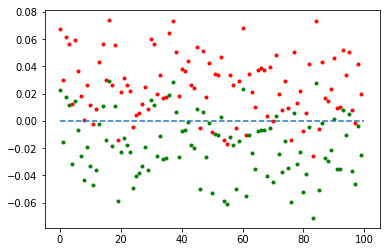

In [11]:
for T in range(100):
    (z, v) = MC_Int2(0, 2.0 * np.pi, 1000)
    e = np.sqrt(v)
    z0 = z + e
    z1 = z - e
    plt.plot(T, z0, 'r.', T, z1, 'g.')
plt.plot([0,100],[0,0],'--')

如图，效果虽然不错（红点大多在虚线上而绿点大都在虚线下），但是这个估算要记录全部的$\varphi(X)$的工作量过高。一个更常用的办法是：

In [12]:
def MC_Int(a, b, times):
    S = 0
    sigma2 = 0
    X = np.random.rand(times)
    for i in range(times):
        F = obj_fun(X[i] * (b - a))
        S += F
        sigma2 += F**2
    z = S / times
    sigma2 = (sigma2 - times * z**2) / ((times - 1) * times)
    return (z, sigma2)

In [13]:
MC_Int2(0, 2.0 * np.pi, 10000)

(0.0031636436691515977, 4.975030472759475e-05)

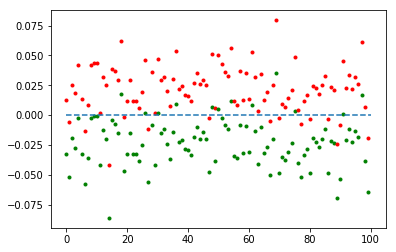

In [14]:
for T in range(100):
    (z, v) = MC_Int2(0, 2.0 * np.pi, 1000)
    e = np.sqrt(v)
    z0 = z + e
    z1 = z - e
    plt.plot(T, z0, 'r.', T, z1, 'g.')
plt.plot([0,100],[0,0],'--')

效果差不多，但效率更高。我们之前分析过，直接用方差来做误差估计，会有一些缺陷（尽管在很多时候实际就这么用！），更准确的判断则需要做区间估计。这里回顾一下求面积时的区间估计。

In [15]:
def area_circle(times):
    inside = 0
    dots = np.random.rand(2, times)
    for i in range(times):
        x = dots[0, i] - 0.5
        y = dots[1, i] - 0.5
        if x * x + y * y < 0.25:
            inside += 1
    return inside / times

In [16]:
area_circle(100)

0.75

还是考虑一个圆面积的估算，我们抽样100次，得到一个估计值，那么区间估计要回答的问题是：真解在哪里？我们能否构建一个区间，覆盖住真解？完全覆盖不可能（总有人品爆炸的时候），那么能否给一个概率，称置信水平$\delta$，也就是说能否给出一个区间，覆盖住真解的概率不小于$1 - \delta$？

首先，这个问题同时也会涉及到参数$n$，也即采样次数。可以想像，在固定$\delta$的前提下，如果$n$大，则区间可以小一些；如果$n$小，则区间会大一些。而在固定$n$的前提下，如果$\delta$小，则区间范围会大；如果$\delta$大，则区间范围会小。

其次，我们考虑如何确定这个区间？作为一种统计估计，我们只能从统计量出发去估计。比如这里只有成功次数$S$，或者面积无偏估计$S/n$等信息（还有更高阶的）。

最后的问题就是我们如何理解统计的规律？如果它是服从概率论的某个定律，我们如何从中获取好处？

带着这些认识，我们重新复习一下区间估计这个关键问题。我们先将程序恢复成计数，也就是只输出成功次数$S$:

In [17]:
def count(times):
    inside = 0
    dots = np.random.rand(2, times)
    for i in range(times):
        x = dots[0, i] - 0.5
        y = dots[1, i] - 0.5
        if x * x + y * y < 0.25:
            inside += 1
    return inside

In [22]:
count(20) # 多抽几次，让它等于14

16

上面是做一次$n = 20$的估计得到的成功次数，现在是直面人品的时候了！在这一次$n = 20$的试验中，我们最有可能得到的结果是多少？这个问题的回答并不唯一，因为我们拥有的信息可能不一样。有些时候，我们对整个抽取过程了解的清楚一点，比如我们知道具体的抽样过程；有些时候，可能只知道这是个独立的抽取过程；甚至有时连独立性也要先判定。所以一切概率分析的出发点，是要先做个假设！现在我们找个好日子过，我们清楚的知道，这是对一个均匀分布的随机投点，是否会落入一个待测面积的区域的判定。这样，由于待测区域是固定不变的，落入期间的概率也是一个定值：
$$
p = \frac{1}{\lambda(\mathscr{R})}.
$$

当然这个$p$我们并不知道（这就是我们要估计的目标！），但我们清楚，这整个抽取过程就是一个$n = 20$的二项分布，也即$S$服从概率分布：
$$
p_i = P\{S = i\} = \binom{n}{i} p^i(1 - p)^{n - i}.
$$
相应的累积分布为：
$$
F(i) = \sum_{j = 0}^i\binom{n}{j} p^j(1 - p)^{n - j}.
$$

可以画出来看看：

In [23]:
from scipy.special import comb

In [24]:
def binomial_CDF(n, mu, i):
    F = 0
    for j in range(i + 1):
        F += comb(n, j) * mu**j * (1 - mu)**(n - j)
    return F

<BarContainer object of 21 artists>

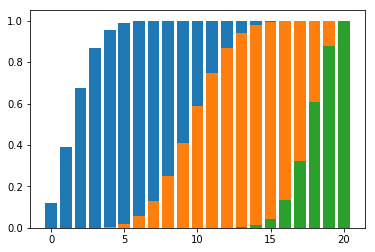

In [25]:
n = 20
S = np.zeros(n + 1)
F1 = np.zeros(n + 1)
F2 = np.zeros(n + 1)
F3 = np.zeros(n + 1)
for i in range(n + 1):
    S[i] = i
    F1[i] = binomial_CDF(n, 0.1, i)
    F2[i] = binomial_CDF(n, 0.5, i)
    F3[i] = binomial_CDF(n, 0.9, i)
plt.bar(S, F1)
plt.bar(S, F2)
plt.bar(S, F3)

现在我们假设$S$服从二项分布，在一组试验中，得到了$S = 16$。我们来估计$p$的可能存在区间。先随便取一个$p=0.7$：

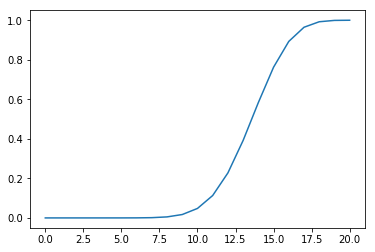

In [26]:
n = 20
S = np.zeros(n + 1)
F1 = np.zeros(n + 1)
for i in range(n + 1):
    S[i] = i
    F1[i] = binomial_CDF(n, 0.7, i)
plt.plot(S, F1)

我们看到，$S$最有可能大概是14左右，这个其实是确定，已知的，因为我们现在明确知道$n = 20$，$p = 0.7$，于是最大可能就是$S = 14$。但这里$p = 0.7$是我们乱猜的。我们事实上不可能知道真正的$p$。这里我们说的是，如果$p$是$0.7$，那么最有可能的是$14$。然而我们现在得到的是$16$，是不是就错了？当然不是。事实上在$p = 0.7$前提下，$S$恰好等于$14$，只是相对最有可能，绝对数值仍然不是很大：

In [27]:
binomial_CDF(20,0.7,14) - binomial_CDF(20,0.7,13)

0.1916389827534426

只有不到两成机会。现在来换一个角度看，$S$有多大的机会严格小于$16$?

In [28]:
binomial_CDF(20,0.7,15)

0.7624922211223986

看来$p = 0.7$似乎是个很糟糕的估计，因为在这个估计下，$S < 16$的可能性不是个小量。但问题的关键来了，**我们究竟是希望这个数再大点好？还是再小点好？**我们现在估计的可不是$S$，我们在估计$p$，我们想得到$p$的**最有可能**范围，因此，我们首先应该去掉$p$的最不可能范围。对于一个**已知**的统计结果$S = 16$，我们现在看到实际上如果$p = 0.7$，则$S < 16$的可能性还有$0.76$，这个不够大，也就是说$p = 0.7$还是很有可能发生的，因为在这个前提下，会有大于$0.2$的概率，出现$S \geq 16$的情况。而我们希望，首先确定一个小概率，比如$\frac{\delta}{2} = 0.05$，使得发生$S \geq 16$的可能性小于$\frac{\delta}{2}$。那么我们怎么调整$p$？往大调还是往小调？观察图像，显然$p$应该再小点。也即我们寻找$p$，使得
$$
\alpha_1 = 1 - F_{15}(n, p) = \frac{\delta}{2},
$$
这样，当$p > \alpha_1$时，出现$S \geq 16$的概率就会大于$\alpha_1$，换言之，**去掉的部分，发生的可能性小于$\alpha_1$**。

In [29]:
a1 = 1 - binomial_CDF(20,0.7,15)
print(a1)

0.23750777887760144


这个$p = 0.7$显然不对，我们需要解上面这个方程，二分法考虑一下：

In [30]:
def func(p, S, n, alpha):
    return binomial_CDF(n, p, S) - alpha

def bisection_root(alpha, S, n, p1, p2, err, tol):
    while (True):
        f1 = func(p1, S, n, alpha)
        if np.abs(f1) < tol:
            return p1
        p = (p1 + p2) * 0.5
        fz = func(p, S, n, alpha)
        if np.abs(fz) < tol:
            return p
        if fz * f1 < 0:
            p2 = p
        else:
            p1 = p
        p = (p1 + p2) * 0.5
        if (np.abs(p1 - p2) < err):
            return p

In [31]:
EPS = 1e-7 #精度
p1 = bisection_root(0.995 + EPS, 15, 20, 0, 1, EPS, EPS)
print(p1)

0.4933910369873047


注意上面加一个误差界以确保$p < p_1$时$S \geq 16$的概率能严格小于$\frac{\delta}{2}$。检查一下：

In [32]:
1 - binomial_CDF(20,p1,15)

0.004999985449014699

$p$稍微大一点，$S >= 16$发生的概率就超过$\frac{\delta}{2}$了:

In [33]:
1 - binomial_CDF(20, p1 + EPS * 2, 15)

0.00500001097632452

换言之，既然现在我们观察到$S = 16$，又要求有$1 - \frac{\delta}{2}$的概率正确，那么，$p$必须大于$p_1$。由此我们找到了区间估计的第一个界。对称地，我们去寻找第二个界。$S > 16$的可能性要足够小！

In [34]:
p2 = bisection_root(0.005 - EPS, 16, 20, 0, 1, EPS, EPS)
print(p2)

0.9642438888549805


检查一下，如果$p > p2$，那么$S \leq 16$的概率就会严格小于：

In [35]:
binomial_CDF(20, p2, 16)

0.004999971697821304

不能再稍微小一点：

In [36]:
binomial_CDF(20, p2 - EPS * 2, 16)

0.005000070650566877

综合起来，对$S = 16$这个观测结果而言，$p$落在$(p_1, p_2)$的可能性严格大于$1 - \delta$。

总结一下，实际上区间估计，不是估计！它是从一个实际统计量出发，在先验假设（服从二项分布）的前提下，直接拎出两个分布函数，一个是$F_{S - 1}(n, p)$，一个是$F_S(n, p)$，然后在偏左的$F_{S - 1}$中，直接砍掉$[0, \alpha_1]$部分，一刀砍在$p_1$；而在偏右的$F_S$中，砍掉$[\alpha_2, 1]$部分，一刀砍在$p_2$，从而确保在$p \in (p_1, p_2)$的可能性严格大于$\alpha_2 - \alpha_1$。一般我们取$\alpha_1 = \frac{\delta}{2}$，$\alpha_2 = 1 - \frac{\delta}{2}$，于是$P\{p_1 < p < p_2\} > 1 -\delta$。显然，从不同的假设出发，我们的先验分布未必是二项分布，也可以是正态分布（$n$充分大），或其他合理的假设。